[ 0.55  0.4  -0.05 -0.1  -0.7 ]
实现了一致性，时间: 5.604000000000206
总触发次数: 120


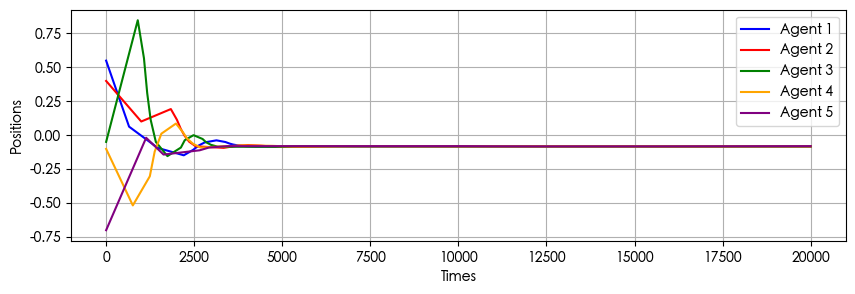

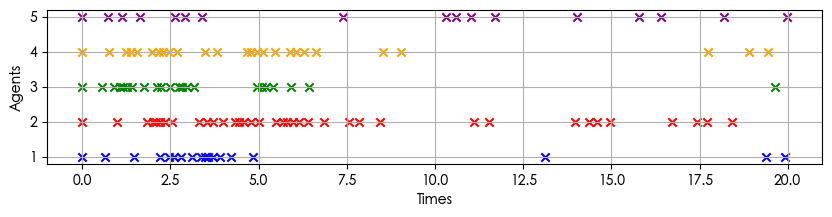

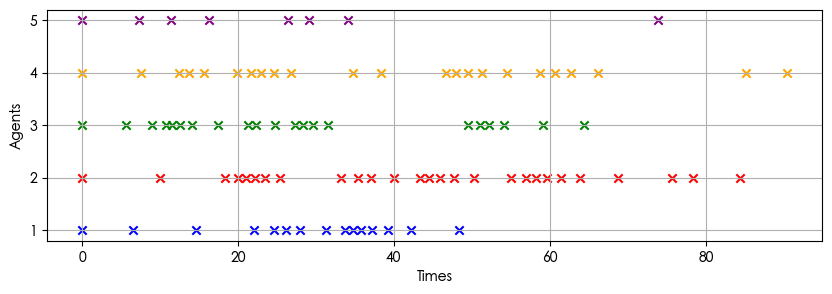

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

# 设置中文字体为macOS中的常见中文字体
rcParams['font.sans-serif'] = ['PingFang SC', 'Heiti TC', 'Arial Unicode MS']
rcParams['axes.unicode_minus'] = False  # 解决负号无法显示的问题

class Agent:
    def __init__(self, initial_position, index):
        self.position = initial_position
        self.index = index
        self.neighbors = []
        self.last_broadcast_position = self.position  #存储了该智能体最近一次广播的位置
        self.trigger_points = []
        self.u_i = 0
        #self.c_0 = 0.0001
        #self.c_1 = 0.2499
        #self.alpha = 0.4699
        self.c_0 = 0.00049
        self.c_1 = 1.2
        self.alpha = 1.4
        self.trigger_count = 0
        self.consensus_time = None  # 记录实现一致性的时间
        self.a = 0.005
         
    def add_neighbor(self, neighbor):
        if neighbor not in self.neighbors:
            self.neighbors.append(neighbor)
            neighbor.neighbors.append(self)

    def is_neighbor(self, agent):
        return agent in self.neighbors
    
    def update_position(self, t, dt):
        e_i = self.last_broadcast_position - self.position
        trigger_condition = np.abs(e_i) - (self.c_0 + self.c_1 * np.exp(- self.alpha * t))
        
        # 如果事件触发函数大于等于0，则更新位置
        if trigger_condition >= 0 or t == 0:
            self.u_i = - sum((self.last_broadcast_position - neighbor.last_broadcast_position) for neighbor in self.neighbors)
            self.position += self.u_i * dt
            self.last_broadcast_position = self.position
            #记录触发的相关信息
            self.trigger_points.append((t, self.position))
            self.trigger_count += 1
        else:
            self.position += self.u_i * dt

        # 检查一致性
        positions = np.array([agent.position for agent in agents])
        max_diff = np.max(positions) - np.min(positions)
        if max_diff <= self.a and self.consensus_time is None:
            self.consensus_time = t  # 更新一致性时间
        elif max_diff > self.a:
            self.consensus_time = None  # 失去一致性


# 初始化参数和智能体
num_agents = 5
num_iterations = 20
dt = 0.001
np.random.seed(0)
#agents = [Agent(np.random.uniform(-1, 1), i) for i in range(num_agents)]
#initial_positions = np.linspace(-1, 1, num_agents)
initial_positions = [0.55, 0.4, -0.05, -0.1, -0.7]
agents = [Agent(pos, i) for i, pos in enumerate(initial_positions)]  

print(np.array([agent.position for agent in agents]))

# 定义邻居关系
agents[0].add_neighbor(agents[1])
agents[0].add_neighbor(agents[2])
agents[1].add_neighbor(agents[2])
agents[2].add_neighbor(agents[3])
agents[3].add_neighbor(agents[4])

L = np.array([[ 2, -1, -1,  0,  0],
              [-1,  2, -1,  0,  0],
              [-1, -1,  3, -1,  0],
              [ 0,  0, -1,  2, -1],
              [ 0,  0,  0, -1,  1]])

# 计算拉普拉斯矩阵的特征值
eigenvalues = np.linalg.eigvalsh(L)
# 谱范数是所有特征值的绝对值中的最大值
spectral_norm = np.max(np.abs(eigenvalues))
# 第二小的特征值，也被称为网络的代数连通性
second_smallest_eigenvalue = np.partition(eigenvalues, 1)[1]

# 运行模拟
positions = np.zeros((int(num_iterations / dt), num_agents))  # 修改此行

t = 0
index = 0  # 新增此行
while index < int(num_iterations / dt):  # 修改此行
    for agent in agents:
        agent.update_position(t, dt)
        positions[index, agent.index] = agent.position  # 修改此行
    t += dt
    index += 1  # 新增此行

# 检查是否实现了一致性并输出结果
consensus_achieved = any(agent.consensus_time is not None for agent in agents)
if consensus_achieved:
    consensus_times = [agent.consensus_time for agent in agents if agent.consensus_time is not None]
    print(f"实现了一致性，时间: {max(consensus_times)}")
else:
    print("没有实现一致性")

trigger_counts = sum(len([point for point in agent.trigger_points]) for agent in agents)
print(f"总触发次数: {trigger_counts}")

# 手动指定每个智能体的颜色
colors = ['blue', 'red', 'green', 'orange', 'purple']  # 每个智能体的颜色

# 绘制结果图
plt.figure(figsize=(10, 3))
for i, agent in enumerate(agents):
    plt.plot(positions[:, i], label=f'Agent {i+1}', color=colors[i])
plt.xlabel('Times')
plt.ylabel('Positions')
#plt.title('智能体随时间变化的位置')
plt.legend()
plt.grid(True)

# 绘制触发事件图，确保智能体的触发事件颜色与其位置图中的颜色相匹配
plt.figure(figsize=(10, 2))
# 收集所有智能体的触发时间点和对应的索引
trigger_events = []
for i, agent in enumerate(agents):
    for t, _ in agent.trigger_points:
        trigger_events.append((t, i + 1, colors[i]))  # 存储时间、智能体索引和颜色
# 按触发时间排序
trigger_events.sort()
# 绘制触发事件
for t, i, color in trigger_events:
    plt.scatter(t, i, marker='x', color=color)  # 使用相应颜色绘制触发事件
plt.xlabel('Times')
plt.ylabel('Agents')
#plt.title('各智能体触发事件')
plt.yticks(range(1, num_agents + 1))  # 设置y轴刻度以匹配智能体的索引
plt.grid(True)

# 创建自定义的时间数组
time = 10
custom_time = np.arange(num_iterations) * dt

# 截取前50个时间步的数据
custom_time = custom_time[:time]

# 绘制触发事件图，使用截取后的时间数组
plt.figure(figsize=(10, 3))
# 收集所有智能体的触发时间点和对应的索引以及颜色
trigger_events = []
for i, agent in enumerate(agents):
    for t, _ in agent.trigger_points:
        if t < time:  # 仅保留时间步前50的触发事件数据
            trigger_events.append((t, i + 1, colors[i]))  # 存储时间、智能体索引和颜色
# 按触发时间排序
trigger_events.sort()
# 绘制触发事件
for t, i, color in trigger_events:
    plt.scatter(t * 10, i, marker='x', color=color)  # 使用之前生成的颜色映射绘制触发事件，保持颜色一致
plt.xlabel('Times')
plt.ylabel('Agents')
#plt.title('各智能体触发事件')
plt.yticks(range(1, num_agents + 1))  # 设置y轴刻度以匹配智能体的索引
plt.grid(True)
plt.show()


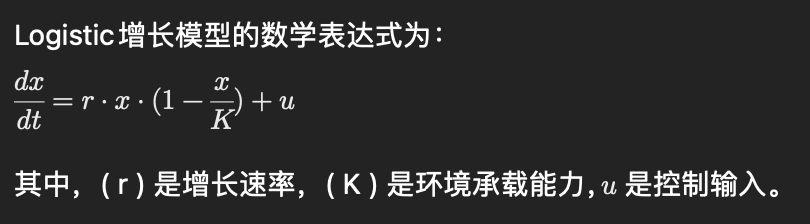
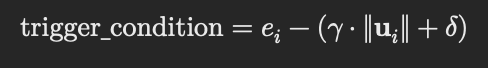

[ 0.55  0.4  -0.05 -0.1  -0.7 ]
没有实现一致性
总触发次数: 177


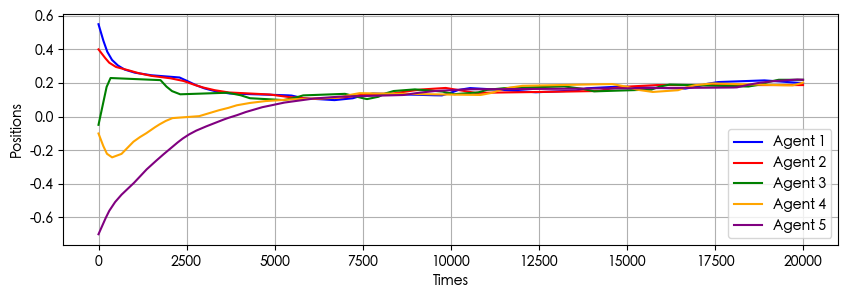

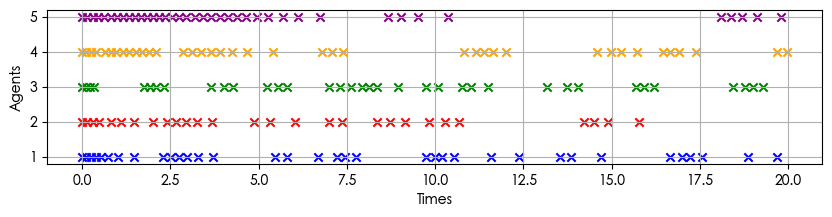

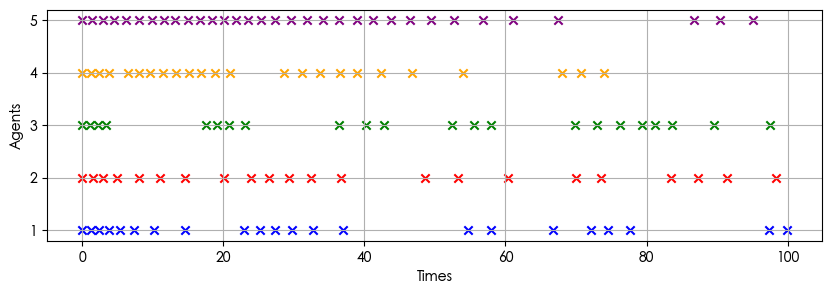

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

# 设置中文字体为macOS中的常见中文字体
rcParams['font.sans-serif'] = ['PingFang SC', 'Heiti TC', 'Arial Unicode MS']
rcParams['axes.unicode_minus'] = False  # 解决负号无法显示的问题

class Agent:
    def __init__(self, initial_position, index, r=0.1, K=1.0, gamma=0.1, delta=0.01):
        self.position = initial_position
        self.index = index
        self.neighbors = []
        self.last_broadcast_position = self.position  # 存储了该智能体最近一次广播的位置
        self.trigger_points = []
        self.u_i = 0
        self.gamma = gamma
        self.delta = delta
        self.trigger_count = 0
        self.consensus_time = None  # 记录实现一致性的时间
        self.a = 0.005
        self.r = r  # 增长速率
        self.K = K  # 环境承载能力
         
    def add_neighbor(self, neighbor):
        if neighbor not in self.neighbors:
            self.neighbors.append(neighbor)
            neighbor.neighbors.append(self)

    def is_neighbor(self, agent):
        return agent in self.neighbors
    
    def nonlinear_dynamics(self, position, control_input):
        # Logistic增长模型
        return self.r * position * (1 - position / self.K) + control_input

    def update_position(self, t, dt):
        e_i = np.linalg.norm(self.last_broadcast_position - self.position)
        trigger_condition = e_i - (self.gamma * np.linalg.norm(self.u_i) + self.delta)
        
        # 如果事件触发函数大于等于0，则更新位置
        if trigger_condition >= 0 or t == 0:
            self.u_i = - sum(self.last_broadcast_position - neighbor.last_broadcast_position for neighbor in self.neighbors)
            # 使用非线性动态模型更新位置
            self.position += self.nonlinear_dynamics(self.position, self.u_i) * dt
            self.last_broadcast_position = self.position
            # 记录触发的相关信息
            self.trigger_points.append((t, self.position))
            self.trigger_count += 1
        else:
            # 使用非线性动态模型更新位置
            self.position += self.nonlinear_dynamics(self.position, self.u_i) * dt

        # 检查一致性
        positions = np.array([agent.position for agent in agents])
        max_diff = np.max(positions) - np.min(positions)
        if max_diff <= self.a and self.consensus_time is None:
            self.consensus_time = t  # 更新一致性时间
        elif max_diff > self.a:
            self.consensus_time = None  # 失去一致性

# 初始化参数和智能体
num_agents = 5
num_iterations = 20
dt = 0.001
np.random.seed(0)
initial_positions = [0.55, 0.4, -0.05, -0.1, -0.7]
agents = [Agent(pos, i) for i, pos in enumerate(initial_positions)]  

print(np.array([agent.position for agent in agents]))

# 定义邻居关系
agents[0].add_neighbor(agents[1])
agents[0].add_neighbor(agents[2])
agents[1].add_neighbor(agents[2])
agents[2].add_neighbor(agents[3])
agents[3].add_neighbor(agents[4])

L = np.array([[ 2, -1, -1,  0,  0],
              [-1,  2, -1,  0,  0],
              [-1, -1,  3, -1,  0],
              [ 0,  0, -1,  2, -1],
              [ 0,  0,  0, -1,  1]])

# 计算拉普拉斯矩阵的特征值
eigenvalues = np.linalg.eigvalsh(L)
# 谱范数是所有特征值的绝对值中的最大值
spectral_norm = np.max(np.abs(eigenvalues))
# 第二小的特征值，也被称为网络的代数连通性
second_smallest_eigenvalue = np.partition(eigenvalues, 1)[1]

# 运行模拟
positions = np.zeros((int(num_iterations / dt), num_agents))

t = 0
index = 0
while index < int(num_iterations / dt):
    for agent in agents:
        agent.update_position(t, dt)
        positions[index, agent.index] = agent.position
    t += dt
    index += 1

# 检查是否实现了一致性并输出结果
consensus_achieved = any(agent.consensus_time is not None for agent in agents)
if consensus_achieved:
    consensus_times = [agent.consensus_time for agent in agents if agent.consensus_time is not None]
    print(f"实现了一致性，时间: {max(consensus_times)}")
else:
    print("没有实现一致性")

trigger_counts = sum(len([point for point in agent.trigger_points]) for agent in agents)
print(f"总触发次数: {trigger_counts}")

# 手动指定每个智能体的颜色
colors = ['blue', 'red', 'green', 'orange', 'purple']  # 每个智能体的颜色

# 绘制结果图
plt.figure(figsize=(10, 3))
for i, agent in enumerate(agents):
    plt.plot(positions[:, i], label=f'Agent {i+1}', color=colors[i])
plt.xlabel('Times')
plt.ylabel('Positions')
plt.legend()
plt.grid(True)

# 绘制触发事件图，确保智能体的触发事件颜色与其位置图中的颜色相匹配
plt.figure(figsize=(10, 2))
trigger_events = []
for i, agent in enumerate(agents):
    for t, _ in agent.trigger_points:
        trigger_events.append((t, i + 1, colors[i]))  # 存储时间、智能体索引和颜色
trigger_events.sort()
for t, i, color in trigger_events:
    plt.scatter(t, i, marker='x', color=color)  # 使用相应颜色绘制触发事件
plt.xlabel('Times')
plt.ylabel('Agents')
plt.yticks(range(1, num_agents + 1))  # 设置y轴刻度以匹配智能体的索引
plt.grid(True)

# 创建自定义的时间数组
time = 10
custom_time = np.arange(num_iterations) * dt
custom_time = custom_time[:time]

# 绘制触发事件图，使用截取后的时间数组
plt.figure(figsize=(10, 3))
trigger_events = []
for i, agent in enumerate(agents):
    for t, _ in agent.trigger_points:
        if t < time:  # 仅保留时间步前50的触发事件数据
            trigger_events.append((t, i + 1, colors[i]))  # 存储时间、智能体索引和颜色
trigger_events.sort()
for t, I, color in trigger_events:
    plt.scatter(t * 10, I, marker='x', color=color)  # 使用之前生成的颜色映射绘制触发事件，保持颜色一致
plt.xlabel('Times')
plt.ylabel('Agents')
plt.yticks(range(1, num_agents + 1))  # 设置y轴刻度以匹配智能体的索引
plt.grid(True)
plt.show()

[ 0.55  0.4  -0.05 -0.1  -0.7 ]
没有实现一致性
总触发次数: 143


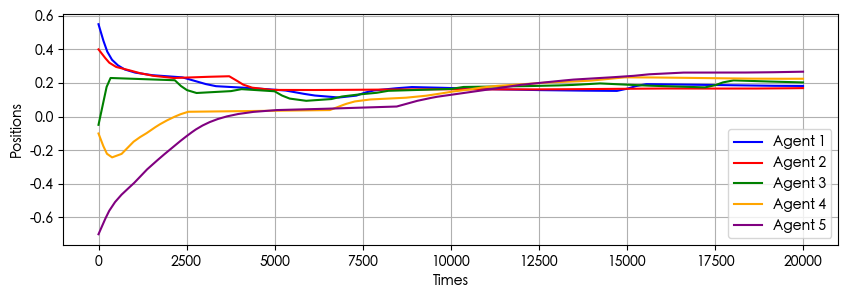

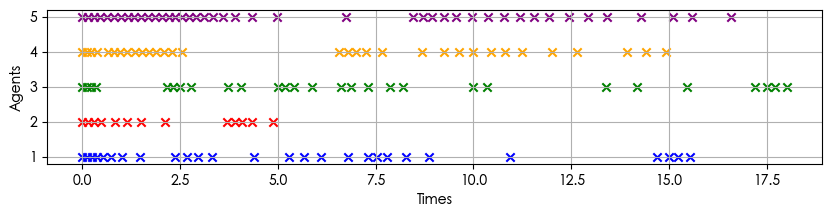

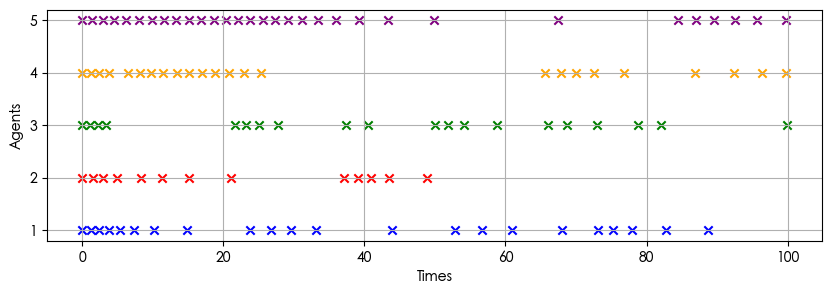

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

# 设置中文字体为macOS中的常见中文字体
rcParams['font.sans-serif'] = ['PingFang SC', 'Heiti TC', 'Arial Unicode MS']
rcParams['axes.unicode_minus'] = False  # 解决负号无法显示的问题

class Agent:
    def __init__(self, initial_position, index, gamma=0.1, delta=0.01):
        self.position = initial_position
        self.index = index
        self.neighbors = []
        self.last_broadcast_position = self.position  # 存储了该智能体最近一次广播的位置
        self.trigger_points = []
        self.u_i = 0
        self.gamma = gamma
        self.delta = delta
        self.trigger_count = 0
        self.consensus_time = None  # 记录实现一致性的时间
        self.a = 0.005
        self.r_base = 0.1  # 基本增长速率
        self.K_base = 1.0  # 基本环境承载能力
         
    def add_neighbor(self, neighbor):
        if neighbor not in self.neighbors:
            self.neighbors.append(neighbor)
            neighbor.neighbors.append(self)

    def is_neighbor(self, agent):
        return agent in self.neighbors
    
    def time_varying_parameters(self, t):
        # 时变参数，可以根据具体需求进行调整
        r = self.r_base + 0.01 * np.sin(t)
        K = self.K_base + 0.1 * np.cos(t)
        return r, K

    def nonlinear_dynamics(self, position, control_input, t):
        # 获取时变参数
        r, K = self.time_varying_parameters(t)
        # Logistic增长模型
        return r * position * (1 - position / K) + control_input

    def update_position(self, t, dt):
        e_i = np.linalg.norm(self.last_broadcast_position - self.position)
        trigger_condition = e_i - (self.gamma * np.linalg.norm(self.u_i) + self.delta)
        
        # 如果事件触发函数大于等于0，则更新位置
        if trigger_condition >= 0 or t == 0:
            self.u_i = - sum(self.last_broadcast_position - neighbor.last_broadcast_position for neighbor in self.neighbors)
            # 使用非线性动态模型更新位置
            self.position += self.nonlinear_dynamics(self.position, self.u_i, t) * dt
            self.last_broadcast_position = self.position
            # 记录触发的相关信息
            self.trigger_points.append((t, self.position))
            self.trigger_count += 1
        else:
            # 使用非线性动态模型更新位置
            self.position += self.nonlinear_dynamics(self.position, self.u_i, t) * dt

        # 检查一致性
        positions = np.array([agent.position for agent in agents])
        max_diff = np.max(positions) - np.min(positions)
        if max_diff <= self.a and self.consensus_time is None:
            self.consensus_time = t  # 更新一致性时间
        elif max_diff > self.a:
            self.consensus_time = None  # 失去一致性

# 初始化参数和智能体
num_agents = 5
num_iterations = 20
dt = 0.001
np.random.seed(0)
initial_positions = [0.55, 0.4, -0.05, -0.1, -0.7]
agents = [Agent(pos, i) for i, pos in enumerate(initial_positions)]  

print(np.array([agent.position for agent in agents]))

# 定义邻居关系
agents[0].add_neighbor(agents[1])
agents[0].add_neighbor(agents[2])
agents[1].add_neighbor(agents[2])
agents[2].add_neighbor(agents[3])
agents[3].add_neighbor(agents[4])

L = np.array([[ 2, -1, -1,  0,  0],
              [-1,  2, -1,  0,  0],
              [-1, -1,  3, -1,  0],
              [ 0,  0, -1,  2, -1],
              [ 0,  0,  0, -1,  1]])

# 计算拉普拉斯矩阵的特征值
eigenvalues = np.linalg.eigvalsh(L)
# 谱范数是所有特征值的绝对值中的最大值
spectral_norm = np.max(np.abs(eigenvalues))
# 第二小的特征值，也被称为网络的代数连通性
second_smallest_eigenvalue = np.partition(eigenvalues, 1)[1]

# 运行模拟
positions = np.zeros((int(num_iterations / dt), num_agents))

t = 0
index = 0
while index < int(num_iterations / dt):
    for agent in agents:
        agent.update_position(t, dt)
        positions[index, agent.index] = agent.position
    t += dt
    index += 1

# 检查是否实现了一致性并输出结果
consensus_achieved = any(agent.consensus_time is not None for agent in agents)
if consensus_achieved:
    consensus_times = [agent.consensus_time for agent in agents if agent.consensus_time is not None]
    print(f"实现了一致性，时间: {max(consensus_times)}")
else:
    print("没有实现一致性")

trigger_counts = sum(len([point for point in agent.trigger_points]) for agent in agents)
print(f"总触发次数: {trigger_counts}")

# 手动指定每个智能体的颜色
colors = ['blue', 'red', 'green', 'orange', 'purple']  # 每个智能体的颜色

# 绘制结果图
plt.figure(figsize=(10, 3))
for i, agent in enumerate(agents):
    plt.plot(positions[:, i], label=f'Agent {i+1}', color=colors[i])
plt.xlabel('Times')
plt.ylabel('Positions')
plt.legend()
plt.grid(True)

# 绘制触发事件图，确保智能体的触发事件颜色与其位置图中的颜色相匹配
plt.figure(figsize=(10, 2))
trigger_events = []
for i, agent in enumerate(agents):
    for t, _ in agent.trigger_points:
        trigger_events.append((t, i + 1, colors[i]))  # 存储时间、智能体索引和颜色
trigger_events.sort()
for t, i, color in trigger_events:
    plt.scatter(t, i, marker='x', color=color)  # 使用相应颜色绘制触发事件
plt.xlabel('Times')
plt.ylabel('Agents')
plt.yticks(range(1, num_agents + 1))  # 设置y轴刻度以匹配智能体的索引
plt.grid(True)

# 创建自定义的时间数组
time = 10
custom_time = np.arange(num_iterations) * dt
custom_time = custom_time[:time]

# 绘制触发事件图，使用截取后的时间数组
plt.figure(figsize=(10, 3))
trigger_events = []
for i, agent in enumerate(agents):
    for t, _ in agent.trigger_points:
        if t < time:  # 仅保留时间步前50的触发事件数据
            trigger_events.append((t, i + 1, colors[i]))  # 存储时间、智能体索引和颜色
trigger_events.sort()
for t, I, color in trigger_events:
    plt.scatter(t * 10, I, marker='x', color=color)  # 使用之前生成的颜色映射绘制触发事件，保持颜色一致
plt.xlabel('Times')
plt.ylabel('Agents')
plt.yticks(range(1, num_agents + 1))  # 设置y轴刻度以匹配智能体的索引
plt.grid(True)
plt.show()